# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('dom.xlsx')
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})

In [4]:
dom.head()

,ds,y,seat
0,2015-01-01,52356,59972
1,2015-01-02,47811,56277
2,2015-01-03,49555,60035
3,2015-01-04,57680,62548
4,2015-01-05,50193,58566


In [5]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2977 non-null   datetime64[ns]
 1   y       2977 non-null   int64         
 2   seat    2977 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 69.9 KB


<AxesSubplot:xlabel='ds'>

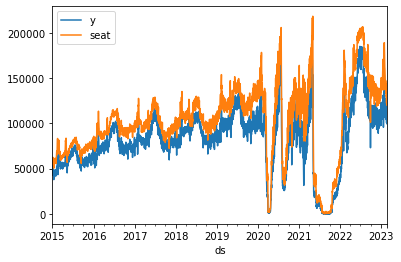

In [6]:
dom.set_index('ds').plot()

In [7]:
holidays = pd.read_excel('holidays.xlsx')

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build models

In [9]:
train = dom[dom['ds'] < '2022-07-01'].copy()
val = dom[(dom['ds'] >= '2022-07-01')&(dom['ds'] < '2023-01-01')].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy()

In [10]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [11]:
dom

,ds,y,seat
0,2015-01-01,52356,59972
1,2015-01-02,47811,56277
2,2015-01-03,49555,60035
3,2015-01-04,57680,62548
4,2015-01-05,50193,58566
...,...,...,...
2972,2023-02-20,101949,125106
2973,2023-02-21,99331,119971
2974,2023-02-22,101744,121959
2975,2023-02-23,109482,124811


In [12]:
seat_df = pd.DataFrame(pd.date_range(start='2023-01-01', end='2023-12-31'),columns=['ds'])

In [13]:
seat_df = seat_df.merge(dom, on = 'ds', how = 'left')

In [14]:
seat_df.drop('y', axis=1, inplace = True)
seat_df.fillna(150000, inplace = True)

In [15]:
help(NeuralProphet)

Help on class NeuralProphet in module neuralprophet.forecaster:

class NeuralProphet(builtins.object)
 |  NeuralProphet(growth: Literal['off', 'linear', 'discontinuous'] = 'linear', changepoints: Optional[list] = None, n_changepoints: int = 10, changepoints_range: float = 0.8, trend_reg: float = 0, trend_reg_threshold: Union[bool, float, NoneType] = False, trend_global_local: str = 'global', yearly_seasonality: Union[Literal['auto'], bool, int] = 'auto', weekly_seasonality: Union[Literal['auto'], bool, int] = 'auto', daily_seasonality: Union[Literal['auto'], bool, int] = 'auto', seasonality_mode: Literal['additive', 'multiplicative'] = 'additive', seasonality_reg: float = 0, season_global_local: Literal['global', 'local'] = 'global', n_forecasts: int = 1, n_lags: int = 0, num_hidden_layers: int = 0, d_hidden: Optional[int] = None, ar_reg: Optional[float] = None, learning_rate: Optional[float] = None, epochs: Optional[int] = None, batch_size: Optional[int] = None, loss_func: Union[str, 

In [16]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,10),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,20),
        'n_lags':trial.suggest_int('n_lags',1,365*3),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        #'newer_samples_weight':trial.suggest_float('newer_samples_weight',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,5),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3)
    }
    future_regressor_params = {'regularization':trial.suggest_float('regularization',0,1)}
    
    # Create the model
    optuna_model = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')  
    optuna_model.add_events(events = ['Labor','Lunar','Summer'], mode='multiplicative')
    optuna_model.add_future_regressor('seat', **future_regressor_params)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    seat = pd.DataFrame(pd.date_range(start='2022-07-01', end='2022-12-31'),columns=['ds'])
    seat = seat.merge(dom, on = 'ds', how = 'left')
    seat.drop('y', axis=1, inplace = True)
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays, regressors_df= seat,n_historic_predictions=True)
    future_df = future_df[future_df['ds'].notna()]
    
    optuna_forecast = optuna_model.predict(df=future_df, decompose = False)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [17]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-03-06 15:03:31,077] A new study created in memory with name: no-name-c2435ddb-59f1-4117-a73d-1159737e1561


In [18]:
study.optimize(objective, n_trials=20)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 157


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:06:28,615] Trial 0 finished with value: 119912.0 and parameters: {'trend_reg': 6.723113307749288, 'seasonality_reg': 4.931976152481779, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 12, 'n_lags': 326, 'ar_reg': 0.46695720506953253, 'learning_rate': 4.95314636995451, 'num_hidden_layers': 0, 'regularization': 0.7697930281899398}. Best is trial 0 with value: 119912.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 57it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:08:43,511] Trial 1 finished with value: 174748.0 and parameters: {'trend_reg': 7.467924242842003, 'seasonality_reg': 3.8366454697161556, 'seasonality_mode': 'additive', 'yearly_seasonality': 22, 'weekly_seasonality': 20, 'n_lags': 575, 'ar_reg': 0.9361309329775258, 'learning_rate': 4.066728755497863, 'num_hidden_layers': 0, 'regularization': 0.5543457845906854}. Best is trial 0 with value: 119912.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 61it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:10:52,738] Trial 2 finished with value: 89125.0 and parameters: {'trend_reg': 2.923398890475657, 'seasonality_reg': 8.179809363873163, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 2, 'n_lags': 451, 'ar_reg': 0.9686526126266715, 'learning_rate': 0.7209109835395155, 'num_hidden_layers': 0, 'regularization': 0.47665615445585996}. Best is trial 2 with value: 89125.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_u

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:13:10,495] Trial 3 finished with value: 191788.0 and parameters: {'trend_reg': 0.7770607521635486, 'seasonality_reg': 2.426933437092893, 'seasonality_mode': 'additive', 'yearly_seasonality': 27, 'weekly_seasonality': 4, 'n_lags': 1018, 'ar_reg': 5.420876988179221, 'learning_rate': 0.20975089793990523, 'num_hidden_layers': 2, 'regularization': 0.6401425405143248}. Best is trial 2 with value: 89125.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 56it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:15:29,871] Trial 4 finished with value: 30680.0 and parameters: {'trend_reg': 8.00678097830046, 'seasonality_reg': 8.365696631737041, 'seasonality_mode': 'additive', 'yearly_seasonality': 24, 'weekly_seasonality': 6, 'n_lags': 602, 'ar_reg': 3.773337872453968, 'learning_rate': 1.0194380115679886, 'num_hidden_layers': 3, 'regularization': 0.9391774228853117}. Best is trial 4 with value: 30680.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._inf

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 53it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:17:47,286] Trial 5 finished with value: 20460.0 and parameters: {'trend_reg': 8.375098432159971, 'seasonality_reg': 4.38461441839196, 'seasonality_mode': 'additive', 'yearly_seasonality': 12, 'weekly_seasonality': 9, 'n_lags': 703, 'ar_reg': 9.7645132221686, 'learning_rate': 3.5267365078750386, 'num_hidden_layers': 2, 'regularization': 0.20538671086664506}. Best is trial 5 with value: 20460.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infe

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:20:46,844] Trial 6 finished with value: 29378.0 and parameters: {'trend_reg': 2.93135806422597, 'seasonality_reg': 1.6840997329118812, 'seasonality_mode': 'additive', 'yearly_seasonality': 39, 'weekly_seasonality': 1, 'n_lags': 343, 'ar_reg': 0.489126869760389, 'learning_rate': 4.373979691374203, 'num_hidden_layers': 2, 'regularization': 0.826558523971149}. Best is trial 5 with value: 20460.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infe

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 47it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:23:12,928] Trial 7 finished with value: 558907.0 and parameters: {'trend_reg': 9.183563138936316, 'seasonality_reg': 1.6158727024981934, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 15, 'n_lags': 901, 'ar_reg': 2.3526653942787257, 'learning_rate': 0.5285945052378606, 'num_hidden_layers': 2, 'regularization': 0.24365630403016658}. Best is trial 5 with value: 20460.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_util

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:25:18,836] Trial 8 finished with value: 18994.0 and parameters: {'trend_reg': 8.26963766824501, 'seasonality_reg': 4.70873922914925, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 6, 'n_lags': 179, 'ar_reg': 2.328241446167479, 'learning_rate': 2.7225426462097873, 'num_hidden_layers': 1, 'regularization': 0.7446472519957872}. Best is trial 8 with value: 18994.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:28:01,174] Trial 9 finished with value: 20441.0 and parameters: {'trend_reg': 6.481940045150245, 'seasonality_reg': 7.723372542380457, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 20, 'n_lags': 117, 'ar_reg': 4.14941284161412, 'learning_rate': 0.7739460456125055, 'num_hidden_layers': 2, 'regularization': 0.8068766138390322}. Best is trial 8 with value: 18994.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_uti

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:29:56,826] Trial 10 finished with value: 18273.0 and parameters: {'trend_reg': 4.862223554813209, 'seasonality_reg': 6.260365290152034, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 8, 'n_lags': 60, 'ar_reg': 6.161359721478034, 'learning_rate': 2.334133758747457, 'num_hidden_layers': 1, 'regularization': 0.42342746178093477}. Best is trial 10 with value: 18273.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_ut

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:31:51,874] Trial 11 finished with value: 18065.0 and parameters: {'trend_reg': 4.4047488755799975, 'seasonality_reg': 6.366583029484113, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 8, 'n_lags': 42, 'ar_reg': 6.837014863548054, 'learning_rate': 2.282703310928876, 'num_hidden_layers': 1, 'regularization': 0.38255236262525505}. Best is trial 11 with value: 18065.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_u

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:33:37,667] Trial 12 finished with value: 18223.0 and parameters: {'trend_reg': 4.576437084943687, 'seasonality_reg': 6.347551013914456, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'n_lags': 11, 'ar_reg': 7.224664567895566, 'learning_rate': 1.9593499797271277, 'num_hidden_layers': 1, 'regularization': 0.3969590662083109}. Best is trial 11 with value: 18065.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_u

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:35:57,693] Trial 13 finished with value: 10609.0 and parameters: {'trend_reg': 4.925916849291945, 'seasonality_reg': 9.999105924610591, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 12, 'n_lags': 7, 'ar_reg': 8.014097092184898, 'learning_rate': 1.784613443431125, 'num_hidden_layers': 1, 'regularization': 0.0001748519866672793}. Best is trial 13 with value: 10609.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:38:32,766] Trial 14 finished with value: 20255.0 and parameters: {'trend_reg': 3.427508194690936, 'seasonality_reg': 9.943734940643663, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 13, 'n_lags': 243, 'ar_reg': 8.194110172835956, 'learning_rate': 1.6606297870648328, 'num_hidden_layers': 1, 'regularization': 0.1045204485505003}. Best is trial 13 with value: 10609.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 55it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:39:16,953] Trial 15 finished with value: 39987953.0 and parameters: {'trend_reg': 1.107659999572721, 'seasonality_reg': 9.975110421354959, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 16, 'n_lags': 28, 'ar_reg': 8.660019133243592, 'learning_rate': 3.0370967102613147, 'num_hidden_layers': 3, 'regularization': 0.03562674950814916}. Best is trial 13 with value: 10609.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:39:32,171] Trial 16 finished with value: 47516.0 and parameters: {'trend_reg': 5.907728469349607, 'seasonality_reg': 6.513656403700189, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 15, 'n_lags': 232, 'ar_reg': 6.881669558317799, 'learning_rate': 1.5043710649564286, 'num_hidden_layers': 1, 'regularization': 0.2953531096097315}. Best is trial 13 with value: 10609.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 51it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:39:35,400] Trial 17 finished with value: 211209.0 and parameters: {'trend_reg': 3.80158716246583, 'seasonality_reg': 3.020098016498421, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 12, 'n_lags': 403, 'ar_reg': 9.959361900668416, 'learning_rate': 2.36256876924515, 'num_hidden_layers': 0, 'regularization': 0.0002466106159944026}. Best is trial 13 with value: 10609.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 9it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:39:40,538] Trial 18 finished with value: 38866.0 and parameters: {'trend_reg': 2.2637313272588715, 'seasonality_reg': 0.22949111939312594, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 6, 'n_lags': 839, 'ar_reg': 8.082340306042653, 'learning_rate': 3.0965493952055674, 'num_hidden_layers': 1, 'regularization': 0.16150109980232638}. Best is trial 13 with value: 10609.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 4it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-06 15:39:47,172] Trial 19 finished with value: 30831.0 and parameters: {'trend_reg': 5.54372802098154, 'seasonality_reg': 8.957469980222573, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 17, 'n_lags': 168, 'ar_reg': 5.403185017269417, 'learning_rate': 1.2778601539761854, 'num_hidden_layers': 0, 'regularization': 0.33147848259119606}. Best is trial 13 with value: 10609.0.


In [22]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 20
Best trial:
  Value: 10609.0
  Params: 
    trend_reg: 4.925916849291945
    seasonality_reg: 9.999105924610591
    seasonality_mode: multiplicative
    yearly_seasonality: 17
    weekly_seasonality: 12
    n_lags: 7
    ar_reg: 8.014097092184898
    learning_rate: 1.784613443431125
    num_hidden_layers: 1
    regularization: 0.0001748519866672793


Trial 13 finished with value: 10609.0 and parameters: {'trend_reg': 4.925916849291945, 'seasonality_reg': 9.999105924610591, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 12, 'n_lags': 7, 'ar_reg': 8.014097092184898, 'learning_rate': 1.784613443431125, 'num_hidden_layers': 1, 'regularization': 0.0001748519866672793}. Best is trial 13 with value: 10609.0

In [26]:
params = {'trend_reg': 4.299088516251899, 'seasonality_reg': 6.124975629047143, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 10, 'n_lags': 2, 'ar_reg': 7.218910336954546, 'learning_rate': 1.9504074742391722, 'num_hidden_layers': 1, 'regularization': 0.5107048420800486}

In [27]:
regularization = params.pop('regularization')

In [28]:
# params = study2.trials[4].params
# params = trial.params

In [29]:
set_random_seed(99)

In [30]:
m = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')
m.add_events(events = ['Labor','Lunar','Summer'], mode='multiplicative')
m.add_future_regressor('seat', regularization = regularization)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 147


Training: 0it [00:00, ?it/s]

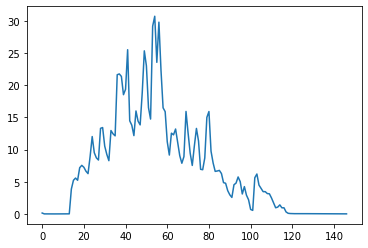

In [31]:
metrics = m.fit(train_val_df,
                freq="D",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


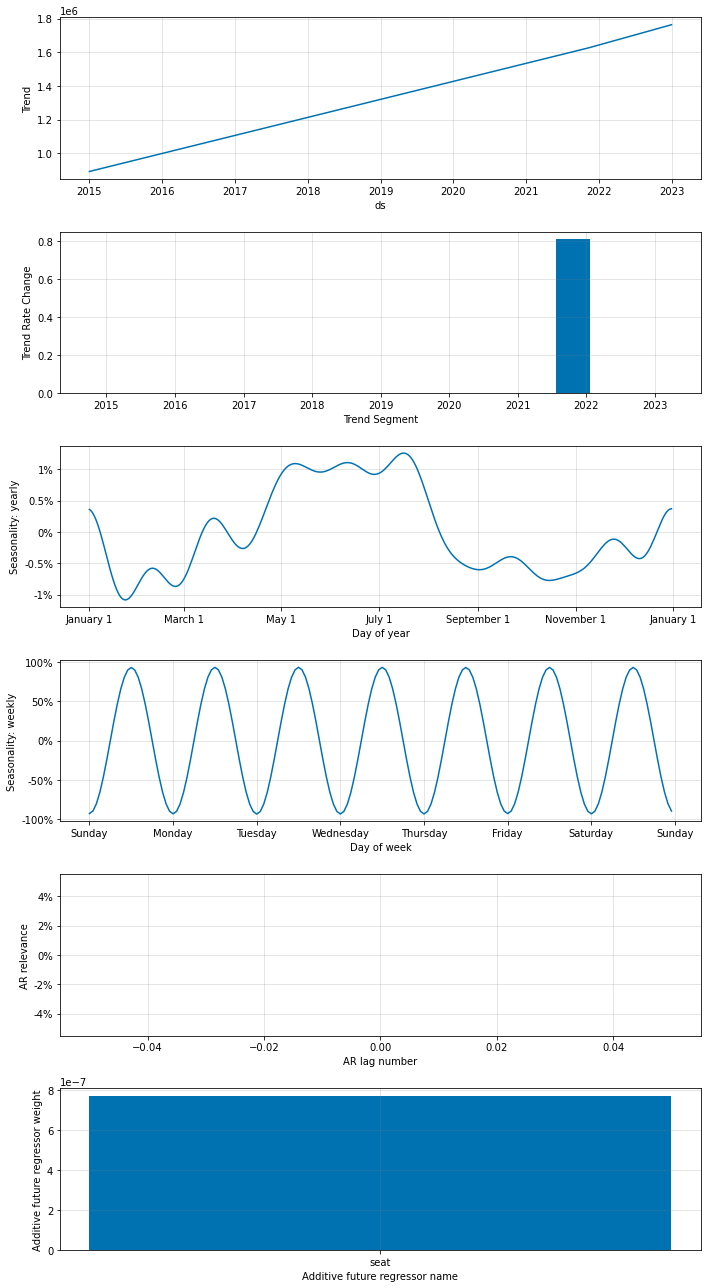

In [32]:
fig_param = m.plot_parameters()

In [33]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays, regressors_df= seat_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [34]:
future

,ds,y,seat,covid_1,covid_2,covid_3,covid_4,Labor,Lunar,Summer
0,2015-01-01,52356,"59,972",0,0,0,0,0,0,0
1,2015-01-02,47811,"56,277",0,0,0,0,0,0,0
2,2015-01-03,49555,"60,035",0,0,0,0,0,0,0
3,2015-01-04,57680,"62,548",0,0,0,0,0,0,0
4,2015-01-05,50193,"58,566",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3282,2023-12-27,None,"150,000",0,0,0,0,0,0,0
3283,2023-12-28,None,"150,000",0,0,0,0,0,0,0
3284,2023-12-29,None,"150,000",0,0,0,0,0,0,0
3285,2023-12-30,None,"150,000",0,0,0,0,0,0,0


In [35]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-02-01')]

,ds,y,seat,covid_1,covid_2,covid_3,covid_4,Labor,Lunar,Summer
2922,2023-01-01,None,"139,257",0,0,0,0,0,0,0
2923,2023-01-02,None,"150,397",0,0,0,0,0,0,0
2924,2023-01-03,None,"141,375",0,0,0,0,0,0,0
2925,2023-01-04,None,"138,438",0,0,0,0,0,0,0
2926,2023-01-05,None,"136,519",0,0,0,0,0,0,0
2927,2023-01-06,None,"144,139",0,0,0,0,0,0,0
2928,2023-01-07,None,"139,056",0,0,0,0,0,0,0
2929,2023-01-08,None,"147,555",0,0,0,0,0,0,0
2930,2023-01-09,None,"144,509",0,0,0,0,0,0,0
2931,2023-01-10,None,"145,066",0,0,0,0,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 80it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


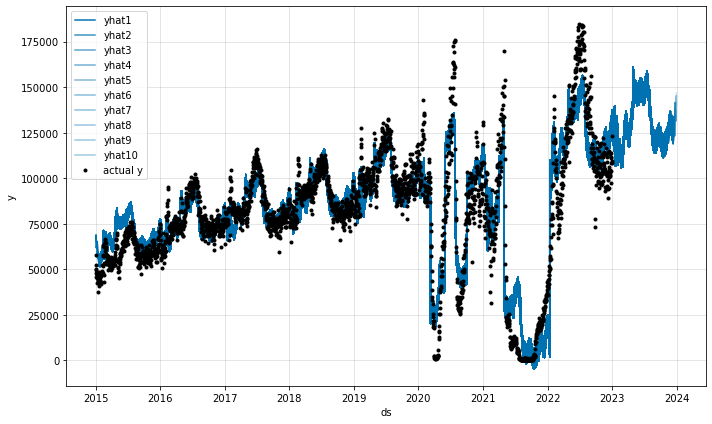

In [36]:
forecast = m.predict(future, decompose = False)
fig = m.plot(forecast)

In [37]:
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,...,yhat356,yhat357,yhat358,yhat359,yhat360,yhat361,yhat362,yhat363,yhat364,yhat365
0,2015-01-01,"52,356",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,"47,811",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,"49,555","65,896",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,"57,680","68,855","68,855",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,"50,193","65,593","65,593","65,593",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"134,677","134,677","134,677","134,677","134,677"
3283,2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"136,827","136,827","136,827","136,827"
3284,2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145,252","145,252","145,252"
3285,2023-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"139,715","139,715"


In [38]:
latest = m.get_latest_forecast(forecast,include_history_data=True)

In [39]:
latest.to_excel('latest.xlsx')

In [40]:
forecast.to_excel('result.xlsx')

In [41]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(predicted['y'][-len(test):], predicted['yhat1'][-len(test):])).round(2)
mape = np.round(np.mean(np.abs(predicted['y'][-len(test):]-predicted['yhat1'][-len(test):])/predicted['y'][-len(test):])*100,2)
tempResults = pd.DataFrame({'Method':'neural prophet', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

NameError: name 'predicted' is not defined

In [ ]:
predicted.to_excel('result.xlsx')

In [ ]:
np.mean(np.abs(predicted['y']-predicted['yhat1'])/predicted['y'])*100

In [ ]:
result = val_df.merge(latest,how = 'left', on = 'ds')

In [ ]:
result